In [46]:
from mads_datasets.base import BaseDatastreamer
from mltrainer.preprocessors import BasePreprocessor
from pathlib import Path
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix
from torch import nn
import torch

from src import datasets, metrics

In [47]:
import tomllib

datadir = Path('../data')
configfile = Path("config.toml")

with configfile.open('rb') as f:
    config = tomllib.load(f)
print(config)

{'ptb': 'heart', 'arrhythmia': 'heart_big'}


In [48]:
trainfile = datadir / (config['arrhythmia'] + '_train.parq')
testfile = datadir / (config['arrhythmia'] + '_test.parq')
trainfile, testfile

(PosixPath('../data/heart_big_train.parq'),
 PosixPath('../data/heart_big_test.parq'))

Get the 1D data into a 2D matrix

In [49]:
shape = (16, 12)
traindataset = datasets.HeartDataset2D(trainfile, target="target", shape=shape)
testdataset = datasets.HeartDataset2D(testfile, target="target", shape=shape)
traindataset, testdataset
if torch.backends.mps.is_available() and torch.backends.mps.is_built():
    device = torch.device("mps")
    print("Using MPS")
else:
    device = "cpu"

traindataset.to(device)
testdataset.to(device)


Using MPS


Let's see how that works. 
Compare this to the 1D data to see if you understand the transformation.

(torch.Size([1, 16, 12]), tensor(0, device='mps:0'))

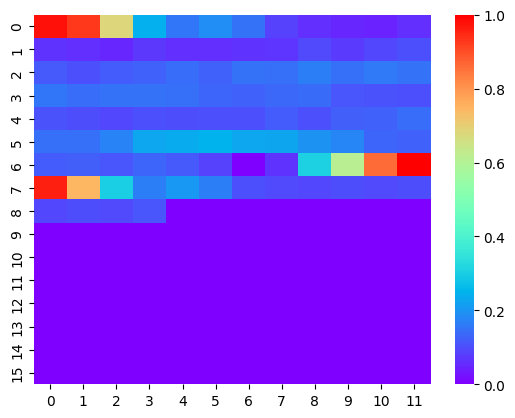

In [50]:
x, y = traindataset[0]
# Assuming your tensor is named 'tensor'
viz = x.squeeze().cpu().numpy()
sns.heatmap(viz, cmap='rainbow')
x.shape, y

Load into a streamer

In [51]:
trainstreamer = BaseDatastreamer(traindataset, preprocessor = BasePreprocessor(), batchsize=32)
teststreamer = BaseDatastreamer(testdataset, preprocessor = BasePreprocessor(), batchsize=32)
len(trainstreamer), len(teststreamer)

(2736, 684)

In [52]:
x, y = next(trainstreamer.stream())
x.shape, y.shape

(torch.Size([32, 1, 16, 12]), torch.Size([32]))

The ConvBlock makes it easier to stack block in the model.
Feel free to experiment with other architectures here:
- adding ideas like resnet, googlenet, squeeze-excite, etc.
- add additional layers like dropout, batchnorm, etc.
- experiment with different ways to go from 4D to 2D tensors

In [53]:
import torch
import torch.nn as nn

class SEBlock(nn.Module):
    def __init__(self, channels, reduction=16):
        super().__init__()
        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channels, channels // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channels // reduction, channels, bias=False),
            nn.Sigmoid(),
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.global_avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y

class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
        )
        self.se = SEBlock(out_channels)

    def forward(self, x):
        x = self.conv(x)
        x = self.se(x)
        return x


In [54]:
import torch.nn as nn

class CNN(nn.Module):
    def __init__(self, config: dict) -> None:
        super().__init__()
        hidden = config['hidden']
        self.convolutions = nn.ModuleList([
            ConvBlock(1, hidden),
        ])

        for i in range(config['num_blocks']):
            self.convolutions.append(ConvBlock(hidden, hidden))
        self.convolutions.append(nn.MaxPool2d(2, 2))

        self.dense = nn.Sequential(
            nn.Flatten(),
            nn.Linear((8*6) * hidden, hidden),  # Pas dimensies aan afhankelijk van input
            nn.ReLU(),
            nn.Linear(hidden, config['num_classes']),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        for conv in self.convolutions:
            x = conv(x)
        x = self.dense(x)
        return x


In [55]:
from src import models

config = {
    'hidden': 32,
    'num_blocks': 3,
    'num_classes': 5,
    'shape': shape,
}

model = models.CNN(config)
model.to(device)
model(x).shape


2025-01-21 15:31:08.295 | INFO     | src.models:__init__:37 - Activation map size: 48
2025-01-21 15:31:08.296 | INFO     | src.models:__init__:38 - Input linear: 1536


torch.Size([32, 5])

In [56]:
yhat = model(x)

The data is unbalanced, so we are interested in much more than just accuracy.

In [57]:
f1micro = metrics.F1Score(average='micro')
f1macro = metrics.F1Score(average='macro')
precision = metrics.Precision('micro')
recall = metrics.Recall('macro')
accuracy = metrics.Accuracy()

In [58]:
import mlflow
mlflow.set_tracking_uri("sqlite:///mads_exam.db")
mlflow.set_experiment("2D conv model")

<Experiment: artifact_location='/Users/rubengoedings/Documents/Ru_hu_ML_exam/notebooks/mlruns/1', creation_time=1736884668897, experiment_id='1', last_update_time=1736884668897, lifecycle_stage='active', name='2D conv model', tags={}>

In [59]:
from mltrainer import Trainer, TrainerSettings, ReportTypes
loss_fn = torch.nn.CrossEntropyLoss()

with mlflow.start_run():
    optimizer = torch.optim.Adam

    settings = TrainerSettings(
        epochs=5,
        metrics=[accuracy, f1micro, f1macro, precision, recall],
        logdir="logs/heart2D",
        train_steps=len(trainstreamer) // 5,
        valid_steps=len(teststreamer) // 5,
        reporttypes=[ReportTypes.TENSORBOARD, ReportTypes.MLFLOW],
        scheduler_kwargs=None,
        earlystop_kwargs=None
    )

    # modify the tags when you change them!
    mlflow.set_tag("model", "Conv2D")
    mlflow.set_tag("dataset", "heart_small_binary")
    mlflow.log_param("scheduler", "None")
    mlflow.log_param("earlystop", "None")

    mlflow.log_params(config)
    mlflow.log_param("epochs", settings.epochs)
    mlflow.log_param("shape0", shape[0])
    mlflow.log_param("optimizer", str(optimizer))
    mlflow.log_params(settings.optimizer_kwargs)

    trainer = Trainer(
        model=model,
        settings=settings,
        loss_fn=loss_fn,
        optimizer=optimizer,
        traindataloader=trainstreamer.stream(),
        validdataloader=teststreamer.stream(),
        scheduler=None,
        )
    trainer.loop()


2025-01-21 15:31:08.876 | INFO     | mltrainer.trainer:dir_add_timestamp:29 - Logging to logs/heart2D/20250121-153108
  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 547/547 [00:04<00:00, 110.38it/s]
2025-01-21 15:31:14.589 | INFO     | mltrainer.trainer:report:191 - Epoch 0 train 0.5726 test 0.3947 metric ['0.8881', '0.8881', '0.5178', '0.8881', '0.5551']
100%|██████████| 547/547 [00:04<00:00, 124.37it/s]
2025-01-21 15:31:19.654 | INFO     | mltrainer.trainer:report:191 - Epoch 1 train 0.2950 test 0.2598 metric ['0.9299', '0.9299', '0.6813', '0.9299', '0.6982']
100%|██████████| 547/547 [00:03<00:00, 138.34it/s]
2025-01-21 15:31:24.277 | INFO     | mltrainer.trainer:report:191 - Epoch 2 train 0.2213 test 0.2099 metric ['0.9416', '0.9416', '0.7496', '0.9416', '0.7433']
100%|██████████| 547/547 [00:04<00:00, 128.54it/s]
2025-01-21 15:31:29.157 | INFO     | mltrainer.trainer:report:191 - Epoch 3 train 0.1879 test 0.1963 metric ['0.9472', '0.9472', '0.7692', '0.9472', '0.7683']
100%|██████████| 547/547 [00:04<00:00, 130.76it/s]
2025-01-21 15:31:33.965 | INFO     | mltrainer.trainer:report:191 - Epoch 4 train 0.1714 test 0.1599 metric [

[Text(0.5, 23.52222222222222, 'Predicted'),
 Text(50.722222222222214, 0.5, 'Target')]

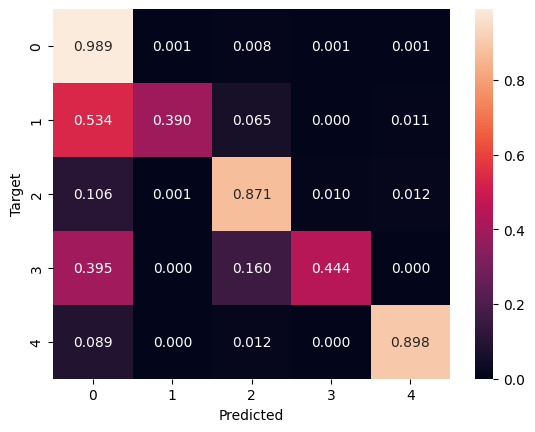

In [60]:
import seaborn as sns
import numpy as np

y_true = []
y_pred = []

testdata = teststreamer.stream()
for _ in range(len(teststreamer)):
    X, y = next(testdata)
    yhat = model(X)
    yhat = yhat.argmax(dim=1) # we get the one with the highest probability
    y_pred.append(yhat.cpu().tolist())
    y_true.append(y.cpu().tolist())

yhat = [x for y in y_pred for x in y]
y = [x for y in y_true for x in y]

cfm = confusion_matrix(y, yhat)
cfm = cfm / np.sum(cfm, axis=1, keepdims=True)

plot = sns.heatmap(cfm, annot=cfm, fmt=".3f")
plot.set(xlabel="Predicted", ylabel="Target")